In [308]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import config as cfg

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

In [309]:
importlib.reload(cfg)
torch.cuda.empty_cache()

In [310]:
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"

In [311]:
model_folder_1 = cfg.CONFIG_ROOT / "experiments/config_20260205-132446"
config_1 = cfg.import_config(model_folder_1 / 'config.json')
model_path_1 = model_folder_1 / 'cptr_model.pth'

model_folder_2 = cfg.CONFIG_ROOT / "experiments/config_20260205-132446"
config_2 = cfg.import_config(model_folder_2 / 'config.json')
model_path_2 = model_folder_2 / 'cptr_best_loss_model.pth'

In [312]:
batch_size_train = config_1["BATCH_SIZE_TRAIN"]
batch_size_test = config_1["BATCH_SIZE_TEST"]

H = config_1["IMG_HEIGHT"]
W = config_1["IMG_WIDTH"]
P = config_1["PATCH_SIZE"]
D_IMG = config_1["IMG_EMBEDDING_DIM"]

# The data will get truncated/padded to this length AFTER tokenization
L = config_1["MAX_TEXT_SEQUENCE_LENGTH"]
D_TEXT = config_1["TEXT_EMBEDDING_DIM"]
DROPOUT_DEC = config_1["DECODER_DROPOUT_PROB"]
RANDOM_SEED = config_1["RANDOM_SEED"]

In [313]:
assert config_1["IMG_HEIGHT"] == config_2["IMG_HEIGHT"], "Image heights do not match between the two models."
assert config_1["IMG_WIDTH"] == config_2["IMG_WIDTH"], "Image widths do not match between the two models."
assert config_1['DATASET'] == config_2['DATASET'], "Datasets do not match between the two models."
assert config_1['TOKENIZER_TYPE'] == config_2['TOKENIZER_TYPE'], "Tokenizers do not match between the two models."
assert config_1['RANDOM_SEED'] == config_2['RANDOM_SEED'], "Random seeds do not match between the two models."

In [314]:
data_loader = DatasetLoader(dataset_type=config_1["DATASET"],
                            img_height=H,
                            img_width=W,
                            batch_size_train=batch_size_train, 
                            batch_size_test=batch_size_test,
                            split_ratio=config_1["SPLIT_RATIO"],
                            shuffle_test=True,
                            seed=RANDOM_SEED)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading COCO dataset...


In [315]:
special_tokens = [cfg.SpecialTokens.PAD, cfg.SpecialTokens.BOS, cfg.SpecialTokens.EOS]
if config_1["TOKENIZER_TYPE"] == cfg.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config_1["TOKENIZER_TYPE"] == cfg.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=cfg.TOKENIZER_DATA_PATH, filename_prefix=config_1["TOKENIZER_FILENAME_PREFIX"])
    
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}, Pad token ID: {pad_idx}")

Tokenizer vocab size: 8577, Pad token ID: 0


In [316]:
transformer_1 = CPTR(num_patches=config_1["NUM_PATCHES"],
                   encoder_arch=config_1["ENCODER_ARCH"],
                   encoding_strategy=config_1["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config_1["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config_1["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config_1["IMG_EMBEDDING_DIM"],
                   patch_size=config_1["PATCH_SIZE"],
                   text_emb_dim=config_1["TEXT_EMBEDDING_DIM"],
                   d_model=config_1["EMBEDDING_DIM"],
                   max_text_seq_len=config_1["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config_1["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config_1["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config_1["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config_1["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config_1["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config_1["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config_1["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config_1["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config_1["DECODER_DROPOUT_PROB"],
                   bias=config_1["USE_BIAS"],
                   use_weight_tying=config_1["USE_WEIGHT_TYING"],
                   sublayer_dropout=config_1["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_1.load_state_dict(torch.load(model_path_1, map_location=device))
transformer_1.eval()

transformer_2 = CPTR(num_patches=config_2["NUM_PATCHES"],
                   encoder_arch=config_2["ENCODER_ARCH"],
                   encoding_strategy=config_2["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config_2["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config_2["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config_2["IMG_EMBEDDING_DIM"],
                   patch_size=config_2["PATCH_SIZE"],
                   text_emb_dim=config_2["TEXT_EMBEDDING_DIM"],
                   d_model=config_2["EMBEDDING_DIM"],
                   max_text_seq_len=config_2["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config_2["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config_2["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config_2["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config_2["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config_2["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config_2["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config_2["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config_2["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config_2["DECODER_DROPOUT_PROB"],
                   bias=config_2["USE_BIAS"],
                   use_weight_tying=config_2["USE_WEIGHT_TYING"],
                   sublayer_dropout=config_2["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_2.load_state_dict(torch.load(model_path_2, map_location=device))
transformer_2.eval()

Initialized CNN ResNet-50 Encoder
Initialized CNN ResNet-50 Encoder


CPTR(
  (encoder): CNNEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

In [317]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    return img * IMAGENET_STD + IMAGENET_MEAN

Caption GT:  A white boat floating on a lake under mountains.
Input image shape: torch.Size([1, 3, 224, 224])


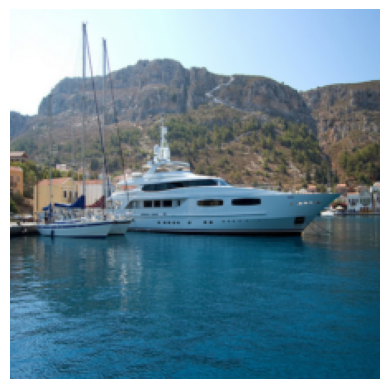

Generated caption by Transformer 1: <bos>A white boat floating on top of a lake.<eos>
Generated caption by Transformer 2: <bos>A boat floating on top of a lake.<eos>


In [318]:
batch = next(iter(train_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu()
img = denormalize(img)
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens_1 = transformer_1.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens_1, torch.Tensor):
        tokens_1 = torch.tensor(tokens_1)

tokens_2 = transformer_2.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens_2, torch.Tensor):
        tokens_2 = torch.tensor(tokens_2)

decoded_caption = tokenizer.decode(tokens_1)
print('Generated caption by Transformer 1:', decoded_caption)
decoded_caption = tokenizer.decode(tokens_2)
print('Generated caption by Transformer 2:', decoded_caption)

Caption GT:  The baseball player in the orange jersey is swinging a bat.
Input image shape: torch.Size([1, 3, 224, 224])


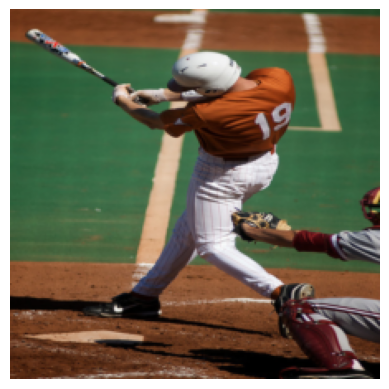

Generated caption by Transformer 1: <bos>A baseball player holding a bat standing on top of a field.<eos>
Generated caption by Transformer 2: <bos>A baseball player holding a bat on top of the field.<eos>


In [392]:
batch = next(iter(test_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu()
img = denormalize(img)
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens_1 = transformer_1.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens_1, torch.Tensor):
        tokens_1 = torch.tensor(tokens_1)

tokens_2 = transformer_2.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens_2, torch.Tensor):
        tokens_2 = torch.tensor(tokens_2)

decoded_caption = tokenizer.decode(tokens_1)
print('Generated caption by Transformer 1:', decoded_caption)
decoded_caption = tokenizer.decode(tokens_2)
print('Generated caption by Transformer 2:', decoded_caption)